In [1]:
# From https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/notebooks/custom_training.ipynb#scrollTo=BMiFcDzE7Qu3

In [2]:
import tensorflow as tf

tf.enable_eager_execution()

In [3]:
# Tensors are immutable stateless objects.
# To maintain state, you can rely on Python as a stateful programming language.
# Using python state
x = tf.zeros([10, 10])
x += 2  # This is equivalent to x = x + 2, which does not mutate the original
        # value of x
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


In [5]:
# Tensorflow does have stateful operations built in.
# tf.assign_sub, tf.scatter_update, etc. mainpulate value stored in
# TensorFlow variable
v = tf.contrib.eager.Variable(1.0)
assert v.numpy() == 1.0

# Re-assign the value
v.assign(3.0)
assert v.numpy() == 3.0

# Use `v` in a TensorFlow operation like tf.square() and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0

In [6]:
# In this tutorial, we'll walk through a trivial example of a 
# simple linear model: f(x) = x * W + b, which has two 
# variables - W and b. Furthermore, we'll synthesize data 
# such that a well trained model would have W = 3.0 and b = 2.0.
class Model(object):
  def __init__(self):
    # Initialize variable to (5.0, 0.0)
    # In practice, these should be initialized to random values.
    self.W = tf.contrib.eager.Variable(5.0)
    self.b = tf.contrib.eager.Variable(0.0)
    
  def __call__(self, x):
    return self.W * x + self.b
  
model = Model()

assert model(3.0).numpy() == 15.0

In [7]:
# L2 loss
def loss(predicted_y, desired_y):
  return tf.reduce_mean(tf.square(predicted_y - desired_y))

In [8]:
# Synthesize training data with noise
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random_normal(shape=[NUM_EXAMPLES])
noise   = tf.random_normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

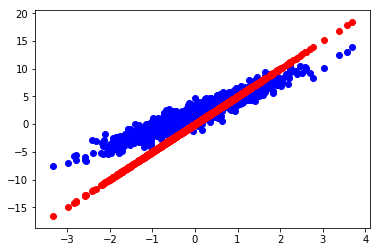

Current loss: 
8.93581


In [10]:
# Visualize current model before training.
# Model prediction in red, training data in blue.
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

In [11]:
# Train the model
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dW, db = t.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

Epoch  0: W=5.00 b=0.00, loss=8.93581
Epoch  1: W=4.57 b=0.38, loss=5.99688
Epoch  2: W=4.23 b=0.68, loss=4.14612
Epoch  3: W=3.97 b=0.93, loss=2.97985
Epoch  4: W=3.76 b=1.13, loss=2.24442
Epoch  5: W=3.60 b=1.29, loss=1.78038
Epoch  6: W=3.47 b=1.41, loss=1.48738
Epoch  7: W=3.37 b=1.52, loss=1.30228
Epoch  8: W=3.29 b=1.60, loss=1.18526
Epoch  9: W=3.23 b=1.67, loss=1.11124


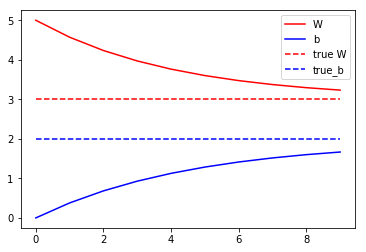

In [12]:
# Repeatedly run through training data and see who W and b evolve.
model = Model()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(model(inputs), outputs)

  train(model, inputs, outputs, learning_rate=0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()
  